### Cab-Driver Agent

In [1]:
#Sometimes this does not hide the warnings, we may need to execute this multiple times.
import warnings
warnings.filterwarnings('ignore')
import os
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')
sns.set_context("notebook")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
# Initialise states to be tracked
# select any 3 Q-values
tracked_values = [((0, 12, 1), (1, 4)), 
                  ((1, 12, 4), (1, 2)),
                  ((2, 14, 2), (2, 3))]


In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [20]:
def plot_tracked_values(states_tracks):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for index, tracked_value in enumerate(tracked_values):
        xaxis = np.asarray(
            range(0, len(states_tracks[tracked_value[0]][tracked_value[1]])))
        plt.subplot(1, 3, index + 1)
        plt.plot(xaxis,
                 np.asarray(states_tracks[tracked_value[0]][tracked_value[1]]))
        plt.title("({},{},{})".format(tracked_value[0][0], tracked_value[0][1],
                                      tracked_value[0][2]) + "_" +
                  "({},{})".format(tracked_value[1][0], tracked_value[1][1]))
    plt.show()

In [7]:
class AgentParam:
    def __init__(self, params):
        self.learning_rate = params.get("learning_rate", 0.01)
        self.action_size = params["action_size"]
        self.state_size = params["state_size"]
        self.action_space = params["action_space"]
        self.epsilon_max = params.get("epsilon_max", 1.0)
        self.epsilon_min = params.get("epsilon_min", 0.0001)
        self.epsilon_decay = params.get("epsilon_decay", 0.0009)
        self.discount_factor = params.get("discount_factor", 0.95)
        self.batch_size = params.get("batch_size", 32)
        self.layers = params["layers"]

    def _print(self):
        attrs = vars(self)
        print("Agent Params: ")
        print("********************************************************")
        for key, value in attrs.items():
            print(key, '->', value)
        print("********************************************************")

In [8]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon_max, epsilon_min, epsilon_decay):
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_epsilon(self, episode):
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min
                                      ) * np.exp(-self.epsilon_decay * episode)
        return epsilon

In [9]:
class ReplayBuffer:
    def __init__(self, batch_size, buffer_size=2000):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def has_enough_experience(self):
        return self.length() > self.batch_size

    def length(self):
        return len(self.memory)

In [10]:
class DQNAgent:
    def __init__(self, agent_param, state_encoder):
        agent_param._print()
        # Define size of state and action
        self.state_size = agent_param.state_size
        self.action_size = agent_param.action_size
        self.action_space = agent_param.action_space

        self.layers = agent_param.layers

        self.discount_factor = agent_param.discount_factor
        self.learning_rate = agent_param.learning_rate
        self.epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)
        self.batch_size = agent_param.batch_size
        self.memory = ReplayBuffer(batch_size=self.batch_size)
        self.epsilon = 1

        # create main model and target model
        self.states_track = collections.defaultdict(dict)
        self.initialise_tracking_states()
        self.state_encoder = state_encoder
        self.model = self.build_model()

    # approximate Q function using Neural Network

    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        for index, layer_dim in enumerate(self.layers):
            if index == 0:
                model.add(
                    Dense(layer_dim,
                          input_dim=self.state_size,
                          activation='relu',
                          kernel_initializer='he_uniform'))
            else:
                model.add(
                    Dense(layer_dim,
                          activation='relu',
                          kernel_initializer='he_uniform'))

        model.add(
            Dense(self.action_size,
                  activation='linear',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, episode, requests):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_greedy_policy.get_epsilon(episode)
        z = np.random.random()
        state_actions_index, state_actions = requests
        if z > self.epsilon:
            # Exploitation: this gets the action corresponding to max q-value of current state
            state_encode = self.state_encoder(state, self.state_size)
            q_value = self.model.predict(state_encode)
            q_value = q_value[0][state_actions_index]

            action_index = np.argmax(q_value)
            action = state_actions[action_index]
        else:
            action = self.action_space[np.random.choice(state_actions_index)]
        return action

    def save_experience(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def train_model(self):
        if not self.memory.has_enough_experience():
            return

        # Sample batch from the memory
        mini_batch = self.memory.sample()
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size))
        actions, rewards, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done>
        for index, experience in enumerate(mini_batch):
            state, action, reward, next_state, is_finished = experience

            update_input[index] = self.state_encoder(state,
                                                     self.state_size,
                                                     reshape=False)
            update_target[index] = self.state_encoder(next_state,
                                                      self.state_size,
                                                      reshape=False)

            actions.append(self.action_space.index(action))
            rewards.append(reward)
            done.append(is_finished)

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        # get your target Q-value on the basis of terminal state
        for index in range(self.batch_size):
            if done[index]:
                # print(True)
                target[index][actions[index]] = rewards[index]

            else:
                target[index][
                    actions[index]] = rewards[index] + self.discount_factor * (
                        np.amax(target_val[index]))

        self.model.fit(update_input,
                       target,
                       batch_size=self.batch_size,
                       epochs=1,
                       verbose=0)

    def memory_length(self):
        return self.memory.length()

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

    def initialise_tracking_states(self):
        for q_values in tracked_values:
            state = q_values[0]
            action = q_values[1]
            self.states_track[state][action] = []

    def update_tracking_states(self):
        for state in self.states_track.keys():
            for action in self.states_track[state].keys():
                encoded_state = self.state_encoder(state, self.state_size)
                prediction = self.model.predict(encoded_state)
                action_index = self.action_space.index(list(action))
                self.states_track[state][action].append(
                    prediction[0][action_index])

In [11]:
env = CabDriver()

In [12]:
def state_encoder(state, state_size, reshape=True):
    state_encode = env.encode_state(state)
    if reshape:
        state_encode = np.reshape(state_encode, [1, state_size])
    return state_encode

In [13]:
agent_param_dict = {
    "action_size": len(env.action_space),
    "state_size": env.state_size,
    "action_space": env.action_space,
    "epsilon_max": 1.0,
    "epsilon_min": 0.000001,
    "epsilon_decay": 0.0004,
    "discount_factor": 0.95,
    "batch_size": 32,
    "layers": [32, 32],
    "learning_rate": 0.001
}

agent_param = AgentParam(agent_param_dict)

agent = DQNAgent(agent_param=agent_param, state_encoder=state_encoder)

total_rewards = []

Agent Params: 
********************************************************
learning_rate -> 0.001
action_size -> 21
state_size -> 36
action_space -> [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3]]
epsilon_max -> 1.0
epsilon_min -> 1e-06
epsilon_decay -> 0.0004
discount_factor -> 0.95
batch_size -> 32
layers -> [32, 32]
********************************************************
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 2,933


In [14]:
Episodes = 15000

### DQN block

In [15]:
log_threshold = Episodes * 0.001
threshold = Episodes * 0.001
model_threshold = Episodes * 0.05

for episode in range(Episodes):

    # tracking total rewards, step count
    total_reward = 0

    state = env.reset()[2]
    is_finished = False

    current_episode = episode + 1

    while not is_finished:

        action = agent.get_action(state, episode, env.get_requests(state))

        reward = env.get_reward(state, action, Time_matrix)

        next_state, is_finished, episode_time_till_now = env.get_next_state(
            state, action, Time_matrix)

        agent.save_experience(state, action, reward, next_state, is_finished)

        # every time step do the training
        agent.train_model()
        total_reward += reward
        state = next_state

        # Store the rewards
        if is_finished and current_episode % log_threshold == 0:
            total_rewards.append(total_reward)
            print(
                "episode: {}, rewards: {}, replay_buffer_size: {}, episode_time: {}, epsilon: {}"
                .format(current_episode, total_reward, agent.memory_length(),
                        episode_time_till_now, agent.epsilon))

    if (current_episode % model_threshold) == 0:
        agent.save("./dqn_cab_driver.h5")

    if (current_episode % threshold) == 0:
        agent.update_tracking_states()


episode: 15, rewards: -176.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.9944156563559471
episode: 30, rewards: -423.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.9884670321363321
episode: 45, rewards: 111.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.9825539928006287
episode: 60, rewards: -153.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.9766763254787819
episode: 75, rewards: 139.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.9708338185741333
episode: 90, rewards: -180.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.9650262617558035
episode: 105, rewards: 171.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.9592534459511197
episode: 120, rewards: 162.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.9535151633380896
episode: 135, rewards: 27.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.9478112073379192
episode: 150, rewards: 53.0, replay_buffer_size: 2000, ep

episode: 1155, rewards: 100.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.6302747690119979
episode: 1170, rewards: 521.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.6265044486699064
episode: 1185, rewards: 647.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.6227566825196295
episode: 1200, rewards: 471.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.619031335641181
episode: 1215, rewards: 415.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.6153282739216709
episode: 1230, rewards: 287.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.6116473640504775
episode: 1245, rewards: 238.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6079884735144477
episode: 1260, rewards: 211.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.6043514705931272
episode: 1275, rewards: 649.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.600736224354018
episode: 1290, rewards: 330.0, replay_buffer_siz

episode: 2325, rewards: 504.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3947121687126921
episode: 2340, rewards: 1025.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3923509923131395
episode: 2355, rewards: 341.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.39000394055568416
episode: 2370, rewards: 158.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.38767092894620914
episode: 2385, rewards: 519.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.38535187349604455
episode: 2400, rewards: 720.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.38304669071894376
episode: 2415, rewards: 795.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3807552976280778
episode: 2430, rewards: 981.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.378477611733048
episode: 2445, rewards: 940.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.37621355103691617
episode: 2460, rewards: 652.0, replay_buf

episode: 3480, rewards: 981.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.24867785411357718
episode: 3495, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2471902602333155
episode: 3510, rewards: 1404.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.24571156519311868
episode: 3525, rewards: 981.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.24424171575980555
episode: 3540, rewards: 1113.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.24278065901863785
episode: 3555, rewards: 1029.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.241328342371415
episode: 3570, rewards: 814.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.23988471353458093
episode: 3585, rewards: 965.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.23844972053734156
episode: 3600, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.23702331171979404
episode: 3615, rewards: 965.0, repl

episode: 4635, rewards: 889.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.15667297351802947
episode: 4650, rewards: 1376.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.1557357561407037
episode: 4665, rewards: 882.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1548041452314184
episode: 4680, rewards: 1173.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.15387810725208018
episode: 4695, rewards: 1147.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.15295760886522175
episode: 4710, rewards: 1096.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.15204261693280186
episode: 4725, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.151133098515012
episode: 4740, rewards: 1517.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.150229020869091
episode: 4755, rewards: 1405.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.14933035144814594
episode: 4770, rewards: 1242.0, repl

episode: 5790, rewards: 1365.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09870784335914623
episode: 5805, rewards: 1498.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09811737547404925
episode: 5820, rewards: 1184.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09753043978906592
episode: 5835, rewards: 1312.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.09694701517444815
episode: 5850, rewards: 1102.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.09636708062684689
episode: 5865, rewards: 1317.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09579061526855569
episode: 5880, rewards: 985.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0952175983467595
episode: 5895, rewards: 1255.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09464800923278717
episode: 5910, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.09408182742136911
episode: 5925, rewards: 1494.0

episode: 6945, rewards: 1332.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06218851642140913
episode: 6960, rewards: 1255.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.06181650846277975
episode: 6975, rewards: 1130.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.06144672586913114
episode: 6990, rewards: 1435.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.06107915532824995
episode: 7005, rewards: 1290.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.06071378360755705
episode: 7020, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06035059755363098
episode: 7035, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05998958409173463
episode: 7050, rewards: 1557.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.05963073022534433
episode: 7065, rewards: 1382.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.059274023035682195
episode: 7080, rewards: 144

episode: 8085, rewards: 1434.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.03941630840268235
episode: 8100, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.039180524610992265
episode: 8115, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.03894615128641959
episode: 8130, rewards: 1371.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03871317999149929
episode: 8145, rewards: 1466.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.038481602339239626
episode: 8160, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.038251409992820055
episode: 8175, rewards: 1634.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0380225946652913
episode: 8190, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03779514811927682
episode: 8205, rewards: 1453.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.03756906216667642
episode: 8220, rewards: 13

episode: 9225, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.024982967859126782
episode: 9240, rewards: 1563.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.024833524829390045
episode: 9255, rewards: 1602.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.024684975773229093
episode: 9270, rewards: 1638.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02453731534286184
episode: 9285, rewards: 1606.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.024390538222496868
episode: 9300, rewards: 2049.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.024244639128141968
episode: 9315, rewards: 1537.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.024099612807414007
episode: 9330, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.023955454039349754
episode: 9345, rewards: 1702.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.023812157634218012
episode: 9360, rewar

episode: 10365, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01583491690706577
episode: 10380, rewards: 1656.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0157401978469607
episode: 10395, rewards: 1525.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.01564604539967795
episode: 10410, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.015552456175719256
episode: 10425, rewards: 1854.0, replay_buffer_size: 2000, episode_time: 707.0, epsilon: 0.015459426805862465
episode: 10440, rewards: 1557.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01536695394104018
episode: 10455, rewards: 1615.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.015275034252219299
episode: 10470, rewards: 1548.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01518366443028111
episode: 10485, rewards: 1674.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.015092841185902126
episode: 10500, 

episode: 11490, rewards: 1715.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.01009715117038509
episode: 11505, rewards: 1495.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.010036755631166941
episode: 11520, rewards: 1295.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.009976721380235377
episode: 11535, rewards: 1271.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.009917046256350887
episode: 11550, rewards: 1324.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009857728111202554
episode: 11565, rewards: 1538.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.009798764809330751
episode: 11580, rewards: 1448.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.009740154228050243
episode: 11595, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.009681894257373787
episode: 11610, rewards: 1377.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009623982799936122
episode: 11

episode: 12615, rewards: 1557.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0064385902092666475
episode: 12630, rewards: 1603.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.006400080313228778
episode: 12645, rewards: 1747.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.006361800784773293
episode: 12660, rewards: 1864.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.00632375024583302
episode: 12675, rewards: 1368.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.006285927326584457
episode: 12690, rewards: 1594.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.006248330665398423
episode: 12705, rewards: 1800.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006210958908791061
episode: 12720, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0061738107113750865
episode: 12735, rewards: 1749.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.006136884735811385
episode: 

episode: 13740, rewards: 1444.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.004105788746033116
episode: 13755, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0040812337522033474
episode: 13770, rewards: 1698.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.004056825647229319
episode: 13785, rewards: 1637.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.004032563552416621
episode: 13800, rewards: 1624.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.004008446594327219
episode: 13815, rewards: 1692.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003984473904748022
episode: 13830, rewards: 1730.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.003960644620659608
episode: 13845, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003936957884205179
episode: 13860, rewards: 1692.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003913412842659666
episode: 

episode: 14865, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002618328860930952
episode: 14880, rewards: 1696.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002602671905602192
episode: 14895, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.002587108610743013
episode: 14910, rewards: 1737.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0025716384160731198
episode: 14925, rewards: 1890.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.002556260764663835
episode: 14940, rewards: 1710.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0025409751029180487
episode: 14955, rewards: 1826.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.002525780880550283
episode: 14970, rewards: 1602.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0025106775505668935
episode: 14985, rewards: 1620.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00249566456924637
episode:

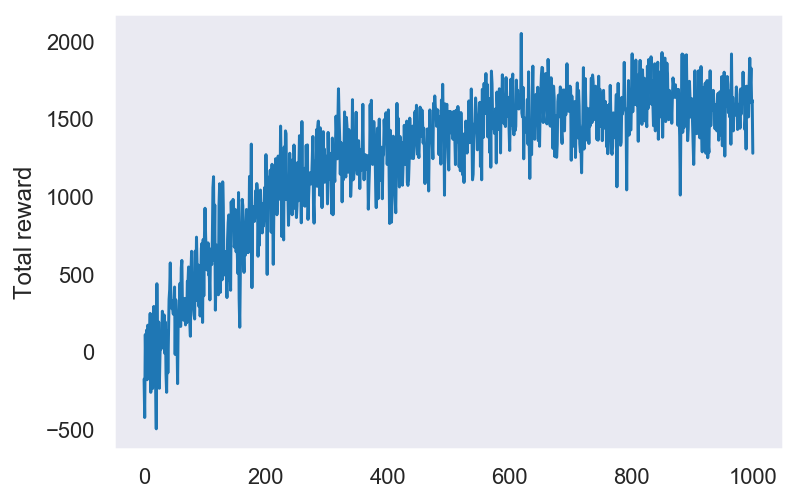

In [16]:
# Plotting total rewards
plt.plot(list(range(len(total_rewards))), total_rewards)
plt.ylabel("Total reward")
plt.show()

### Tracking Convergence

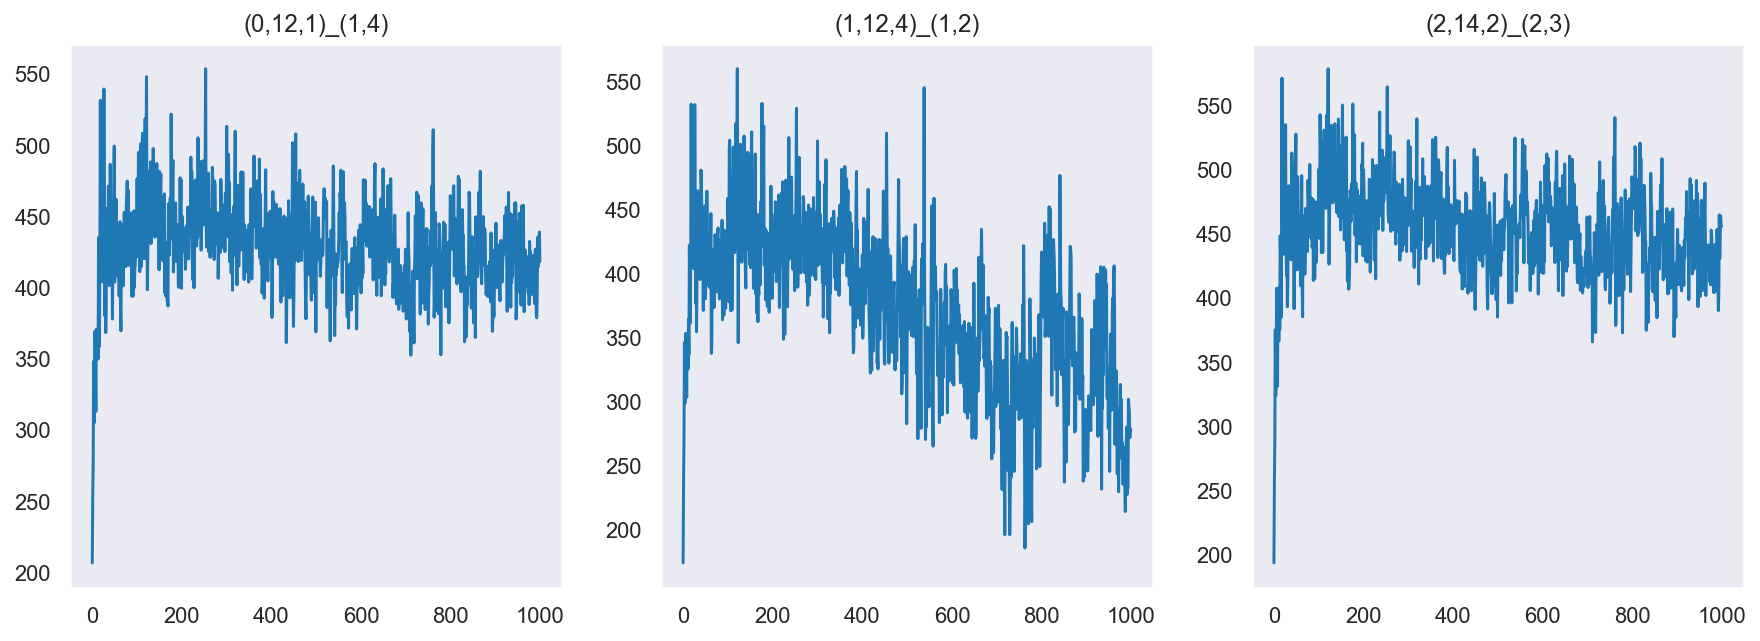

In [21]:
plot_tracked_values(agent.states_track)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [18]:
epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)

time = np.arange(0,Episodes)
epsilon = []
for i in range(0,Episodes):
    epsilon.append(epsilon_greedy_policy.get_epsilon(i))

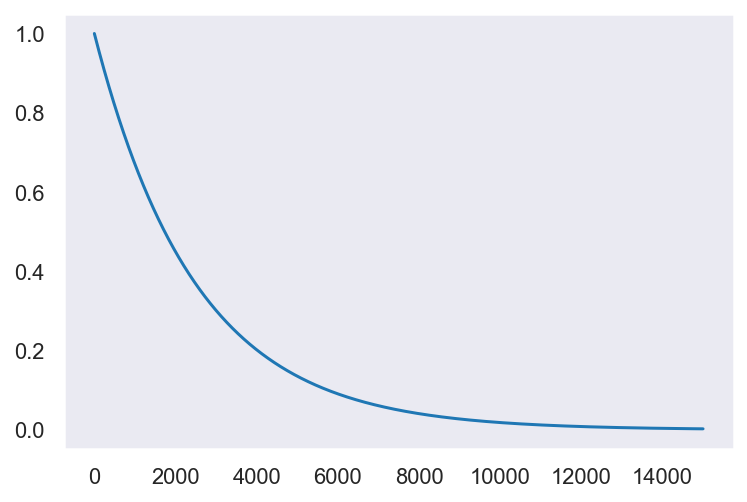

In [19]:
plt.plot(time, epsilon)
plt.show()